# Hipertensión México


In [2]:
%load_ext autoreload
%autoreload 2


import collections
import os
import pickle

import matplotlib.pyplot as plt

import pandas as pd
import scipy.stats as stats
import seaborn as sns
from data_analysis_octopus import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report

import data_analysis_octopus as dao

pd.set_option("display.max_columns", None)

def calculate_psi(expected, actual, buckets=10, axis=0):
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min + 1e-5)
        input += min
        return input
    
    breakpoints = np.linspace(0, 100, buckets + 1)
    
    if axis == 1:
        psi_value = 0
        for i in range(len(expected.T)):
            psi_value += calculate_psi(expected.T[i], actual.T[i], buckets, axis=0)
        return psi_value
    
    expected_percents = np.histogram(scale_range(expected, 0, 100), breakpoints)[0] / len(expected)
    actual_percents = np.histogram(scale_range(actual, 0, 100), breakpoints)[0] / len(actual)
    
    def sub_psi(e_perc, a_perc):
        if a_perc == 0:
            a_perc = 0.0001
        if e_perc == 0:
            e_perc = 0.0001
        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return value
    
    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents)))
    
    return round(psi_value, 4)

def interpret_psi(psi_value):
    if psi_value < 0.1:
        return "No hay cambios significativos"
    elif 0.1 <= psi_value < 0.2:
        return "Pequeños cambios"
    else:
        return "Grandes cambios"

In [3]:
raw_df = pd.read_csv("../data/hipertension/Hipertension_Arterial_Mexico.csv")
raw_df.shape

(4363, 36)

In [4]:
raw_df.head()

,FOLIO_I,sexo,edad,concentracion_hemoglobina,temperatura_ambiente,valor_acido_urico,valor_albumina,valor_colesterol_hdl,valor_colesterol_ldl,valor_colesterol_total,valor_creatina,resultado_glucosa,valor_insulina,valor_trigliceridos,resultado_glucosa_promedio,valor_hemoglobina_glucosilada,valor_ferritina,valor_folato,valor_homocisteina,valor_proteinac_reactiva,valor_transferrina,valor_vitamina_bdoce,valor_vitamina_d,peso,estatura,medida_cintura,segundamedicion_peso,segundamedicion_estatura,distancia_rodilla_talon,circunferencia_de_la_pantorrilla,segundamedicion_cintura,tension_arterial,sueno_horas,masa_corporal,actividad_total,riesgo_hipertension
0,2022_01001004,2,41,14.2,22,4.8,4.0,34,86.0,139,0.58,92.0,4.0,123,103,5.2,2.7,23.4,4.9,0.02,1.1,167.0,20.8,74.55,147.3,0.0,64.70,154.0,48.5,33.5,0.0,107,4,32.889389,120,1
1,2022_01001009,2,65,14.1,9,4.4,3.8,73,130.0,252,0.62,111.0,9.4,131,131,6.2,2.7,23.4,4.9,0.02,1.1,167.0,20.8,2.00,151.0,0.0,96.75,152.2,44.5,41.1,113.7,104,2,1.000000,240,0
2,2022_01001012,2,68,14.2,22,4.8,4.0,34,86.0,139,0.58,92.0,4.0,123,103,5.2,2.7,23.4,4.9,0.02,1.1,167.0,20.8,2.00,151.0,0.0,68.70,144.8,42.3,37.8,103.7,105,1,1.000000,480,0
3,2022_01001013,1,35,15.7,11,6.5,4.1,49,107.0,203,0.91,106.0,7.4,297,105,5.3,2.7,23.4,4.9,0.02,1.1,167.0,20.8,81.50,173.4,98.5,64.70,154.0,48.5,33.5,0.0,117,5,26.265339,275,1
4,2022_01001015,2,65,12.7,7,4.2,4.2,41,76.0,145,0.71,109.0,16.9,136,154,7.0,2.7,23.4,4.9,0.02,1.1,167.0,20.8,2.00,151.0,0.0,97.15,161.3,49.6,42.0,118.9,123,2,1.000000,255,0


In [5]:
target = "riesgo_hipertension"
raw_df[target].value_counts(normalize=True).to_frame()

,proportion
riesgo_hipertension,
1,0.645427
0,0.354573


## Preprocesamiento

In [6]:
# Elimiando columnas que no aportan información
df = raw_df.copy()
df = df.drop(columns=["FOLIO_I"])
# Clasificando features
categorical_features = ["sexo"]
mask = df.columns[df.columns.isin(
    categorical_features + [target])== False]
numerical_features = df[mask].columns.to_list()

df[numerical_features] = df[numerical_features].astype(float)

## Train, Test & Validation

In [7]:
X = df[df.columns[df.columns.isin([target]) == False]]
y = df[[target]]

squeezed_y = y.squeeze()

X_train_raw, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.6, random_state=42, stratify=squeezed_y)

X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

# Guardando target
y_train.to_pickle("../results/10-Hipertension-Mexico/y_train.pickle")
y_test.to_pickle("../results/10-Hipertension-Mexico/y_test.pickle")
# Guardando datos de Validación
X_val_raw.to_pickle("../results/10-Hipertension-Mexico/X_val_raw.pickle")
y_val.to_pickle("../results/10-Hipertension-Mexico/y_val.pickle")

## Procesamiento

In [8]:
X_train_raw.describe().round(2)

,sexo,edad,concentracion_hemoglobina,temperatura_ambiente,valor_acido_urico,valor_albumina,valor_colesterol_hdl,valor_colesterol_ldl,valor_colesterol_total,valor_creatina,resultado_glucosa,valor_insulina,valor_trigliceridos,resultado_glucosa_promedio,valor_hemoglobina_glucosilada,valor_ferritina,valor_folato,valor_homocisteina,valor_proteinac_reactiva,valor_transferrina,valor_vitamina_bdoce,valor_vitamina_d,peso,estatura,medida_cintura,segundamedicion_peso,segundamedicion_estatura,distancia_rodilla_talon,circunferencia_de_la_pantorrilla,segundamedicion_cintura,tension_arterial,sueno_horas,masa_corporal,actividad_total
count,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00,1745.00
mean,1.60,47.58,14.23,21.42,4.80,3.88,36.32,87.68,143.78,0.62,97.48,6.89,134.14,109.87,5.44,6.95,22.66,5.26,0.09,1.14,200.61,21.14,58.10,156.04,67.39,65.67,153.79,48.48,34.04,19.87,123.97,3.29,22.39,485.30
std,0.49,14.30,1.17,3.01,0.81,0.44,9.71,16.93,25.28,0.22,62.48,11.62,63.93,29.48,1.03,16.99,3.84,1.67,0.30,0.50,333.61,2.90,33.42,15.46,46.60,7.56,8.49,3.57,4.29,40.34,22.85,3.45,12.40,753.21
min,1.00,4.00,5.50,2.00,0.20,1.00,13.00,11.10,41.00,0.28,41.00,0.60,35.00,74.00,4.20,0.90,5.10,3.71,0.02,0.10,33.50,0.01,2.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,10.00
25%,1.00,37.00,14.20,22.00,4.80,4.00,34.00,86.00,139.00,0.58,92.00,4.00,123.00,103.00,5.20,2.70,23.40,4.90,0.02,1.10,167.00,20.80,49.00,151.00,0.00,64.70,154.00,48.50,33.50,0.00,111.00,2.00,19.55,240.00
50%,2.00,49.00,14.20,22.00,4.80,4.00,34.00,86.00,139.00,0.58,92.00,4.00,123.00,103.00,5.20,2.70,23.40,4.90,0.02,1.10,167.00,20.80,66.90,154.50,89.40,64.70,154.00,48.50,33.50,0.00,122.00,3.00,26.05,380.00
75%,2.00,58.00,14.20,22.00,4.80,4.00,34.00,86.00,139.00,0.58,92.00,4.20,123.00,103.00,5.20,2.70,23.40,4.90,0.02,1.10,167.00,20.80,79.30,162.80,101.10,64.70,154.00,48.50,33.50,0.00,136.00,4.00,30.36,580.00
max,2.00,93.00,19.90,35.00,11.00,5.30,279.00,200.00,292.00,8.27,2372.00,264.10,914.00,447.00,17.20,186.90,114.40,50.00,2.91,16.20,7520.00,50.90,145.80,186.20,152.10,126.40,182.60,97.30,102.30,165.00,200.00,99.00,60.51,17820.00


In [9]:
dao.freq_discrete(X_train_raw, categorical_features)

Feature: sexo


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
sexo,,,,
2,"1,051",60.23%,"1,051",60.23%
1,694,39.77%,"1,745",100.00%


### Detección y remoción de variables poco pobladas
para valores con cantidad de valores nulos > 65%

In [16]:
THRESHOLD = 65
completitud_df = dao.DataViz.completitud(X_train_raw)
remove_features = completitud_df[completitud_df["% valores nulos"] >= THRESHOLD]
if remove_features.empty:
    print("No hay variables con valores nulos > 65%")
else:
    remove_features

No hay variables con valores nulos > 65%


### Detección y remoción de variables unitarias
cuando el 90% de la información se agrupe dentro de una sola variable

In [28]:
dfs_list = []
for c in X_train_raw.columns:
    tmp_count = dao.count_percentage(X_train_raw, c)
    
    tmp_df = tmp_count[tmp_count["porcentaje"] >= 90]

    if not tmp_df.empty:
        dfs_list.append(dao.create_feature_dataframe(tmp_df, c))

if dfs_list:
    unit_vars = pd.concat(dfs_list).reset_index(drop=True)
    unit_vars
else:
    print("No hay variables unitarias")

No hay variables unitarias


### Transformación de los datos
Detección y tratamiento de valores ausentes y escalamiento <br>
1. Númericas:
    - MixMaxScaler
    - SimpleImputer(strategy="median")
2. Categoricas:
    - SimpleImputer(strategy="most_frequent")
    - OneHotEncoder(drop="first", handle_unknown="ignore")

In [30]:
X_train, X_test, preprocessor = dao.transform_data(
    X_train_raw, X_test_raw, numerical_features=numerical_features,
    categorical_features=categorical_features)

# Checkpoint
with open("../results/10-Hipertension-Mexico/preprocessor.pickle", "wb") as f:
    pickle.dump(preprocessor, f)

with open("../results/10-Hipertension-Mexico/numerical_features.pickle", "wb") as f:
    pickle.dump(numerical_features, f)

with open("../results/10-Hipertension-Mexico/categorical_features.pickle", "wb") as f:
    pickle.dump(categorical_features, f)

X_train.to_pickle("../results/10-Hipertension-Mexico/X_train.pickle")
X_test.to_pickle("../results/10-Hipertension-Mexico/X_test.pickle")

In [11]:
# Checkpoint
with open("../results/10-Hipertension-Mexico/numerical_features.pickle", "rb") as f:
    numerical_features = pickle.load(f)

with open("../results/10-Hipertension-Mexico/categorical_features.pickle", "rb") as f:
    categorical_features = pickle.load(f)

target = "riesgo_hipertension"

X_train = pd.read_pickle("../results/10-Hipertension-Mexico/X_train.pickle")
X_test = pd.read_pickle("../results/10-Hipertension-Mexico/X_test.pickle")
y_train = pd.read_pickle("../results/10-Hipertension-Mexico/y_train.pickle")
y_test = pd.read_pickle("../results/10-Hipertension-Mexico/y_test.pickle")

processed_df = pd.concat([y_train, X_train], axis=1)

## Análisis

### Distribuciones de las características
por categoría

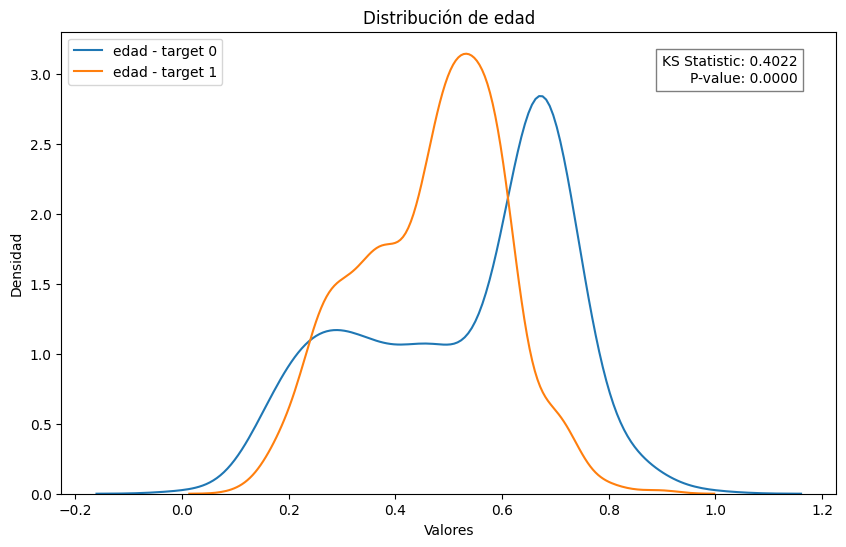

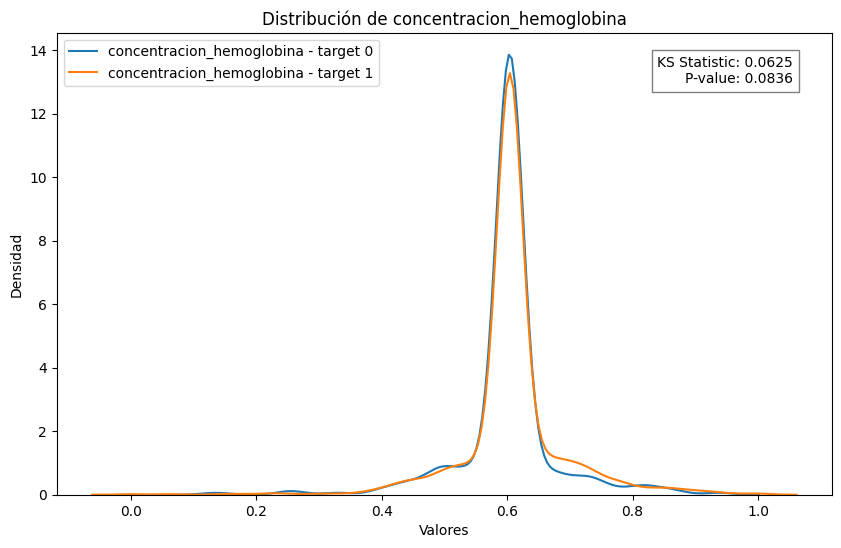

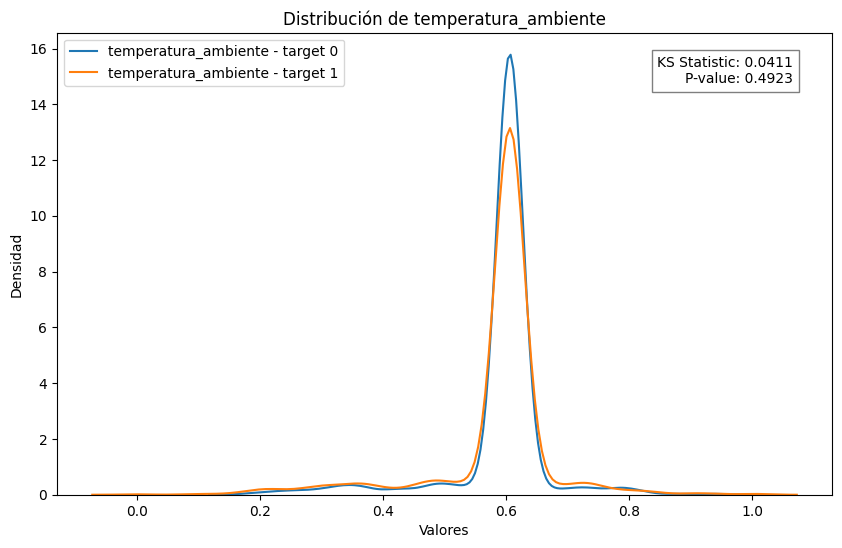

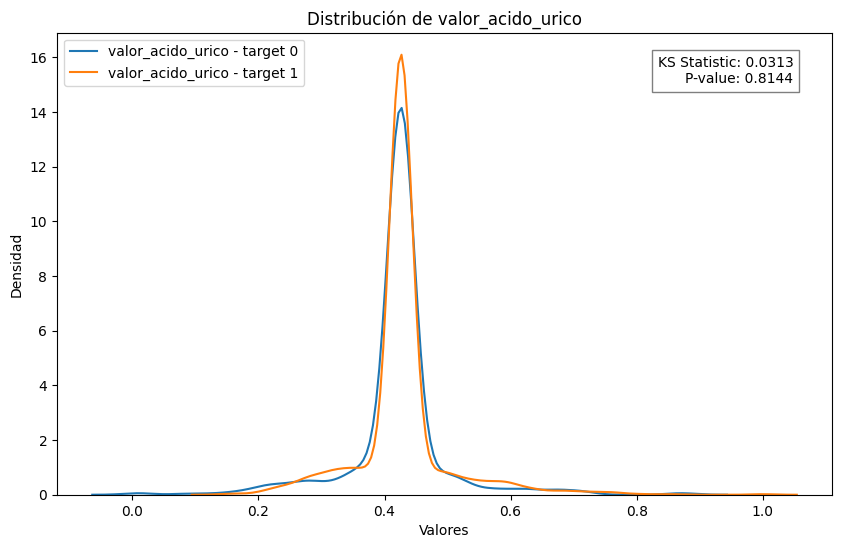

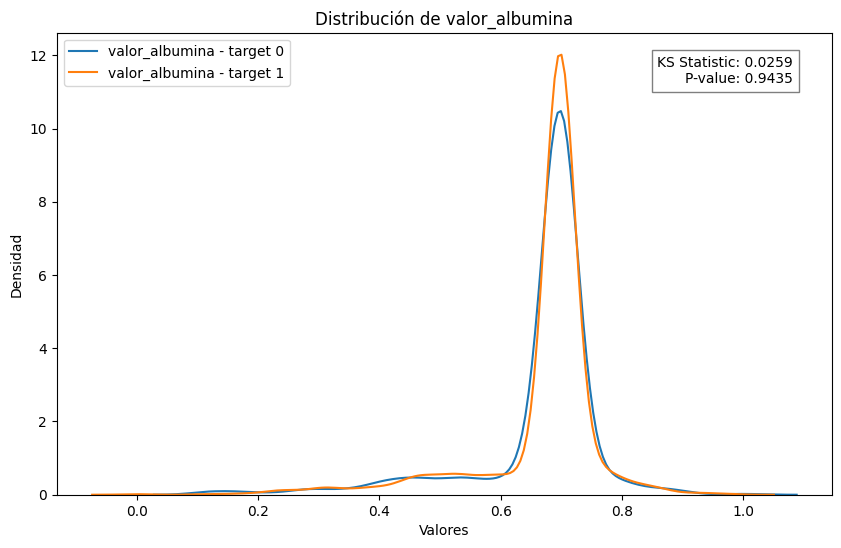

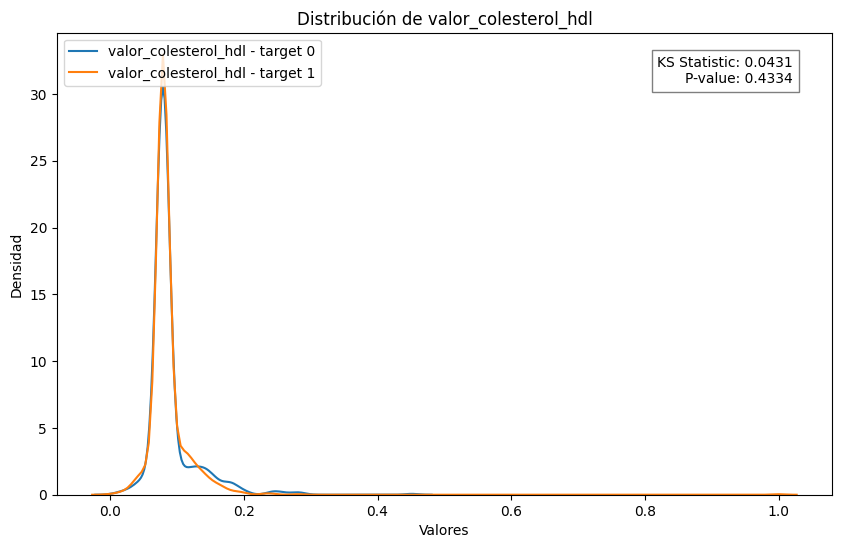

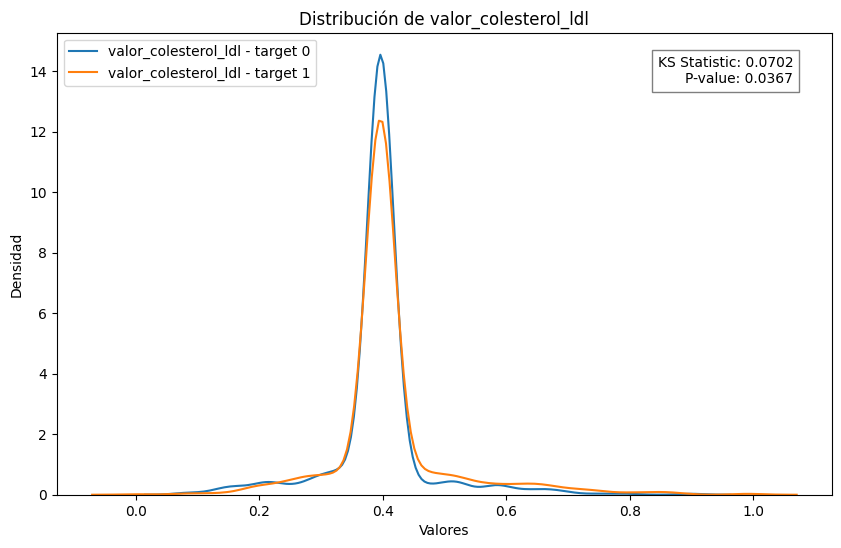

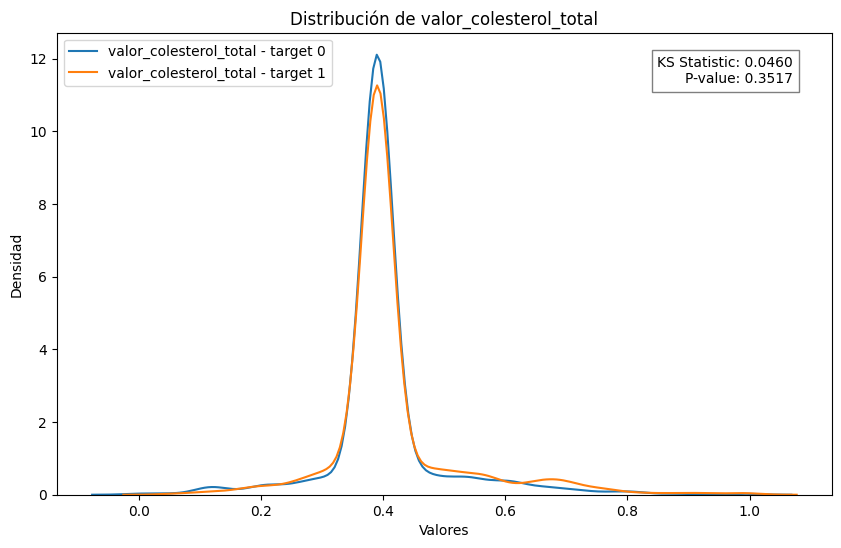

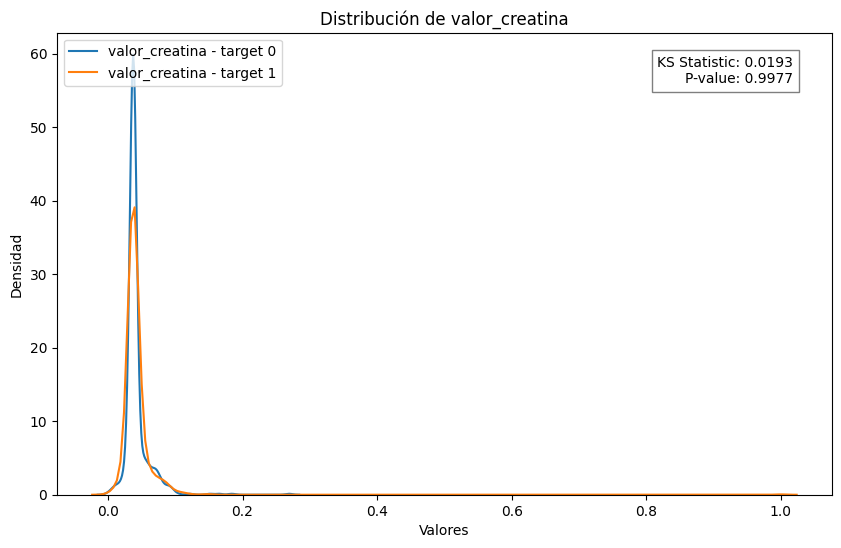

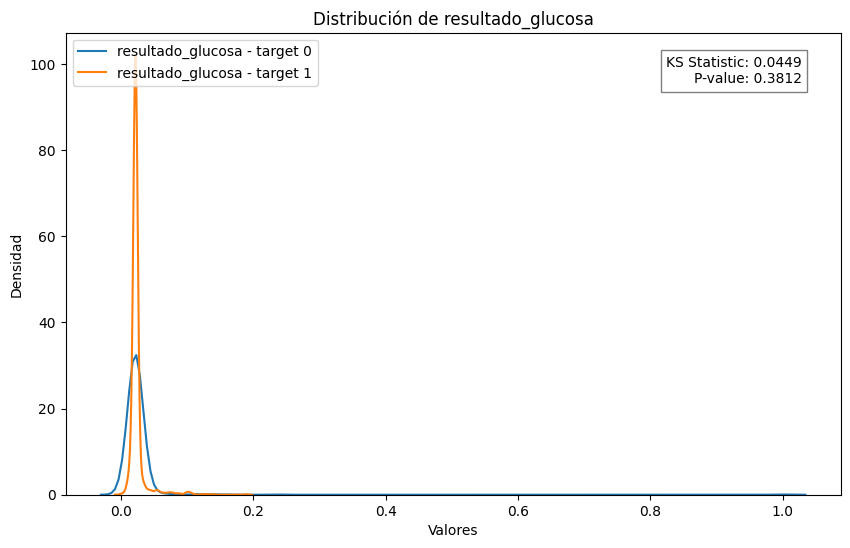

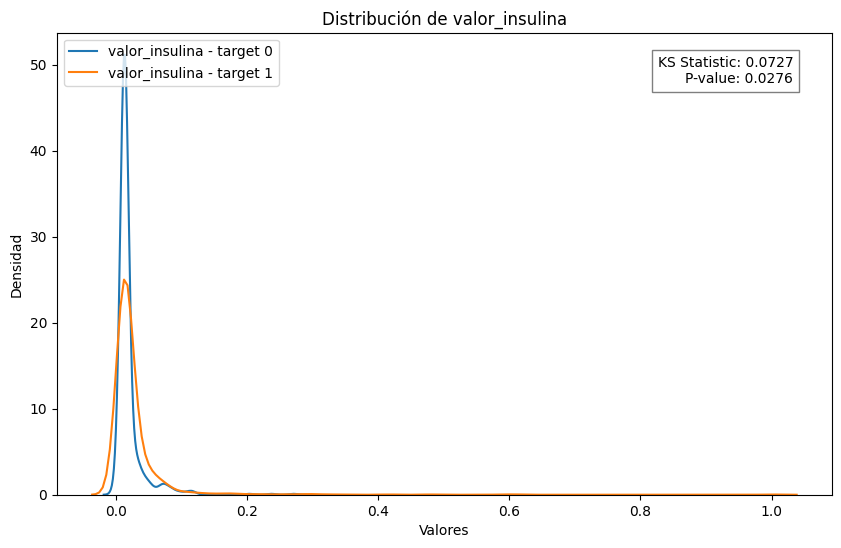

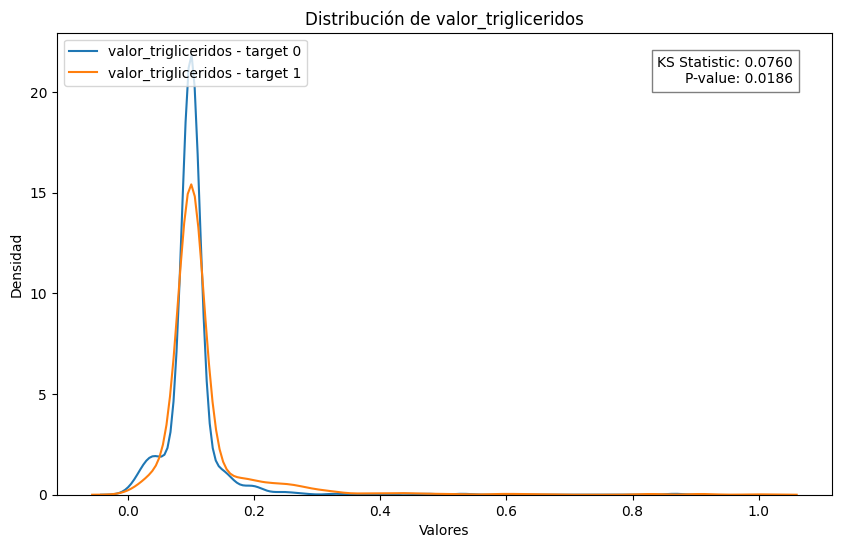

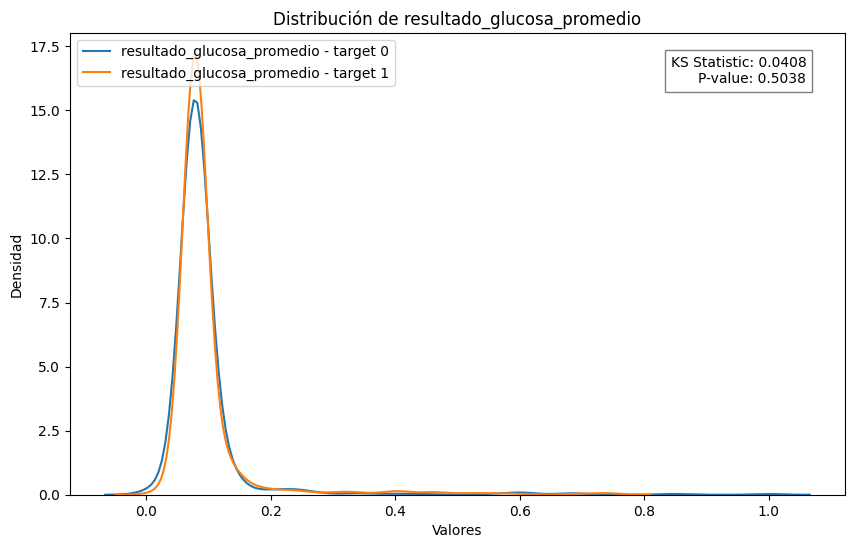

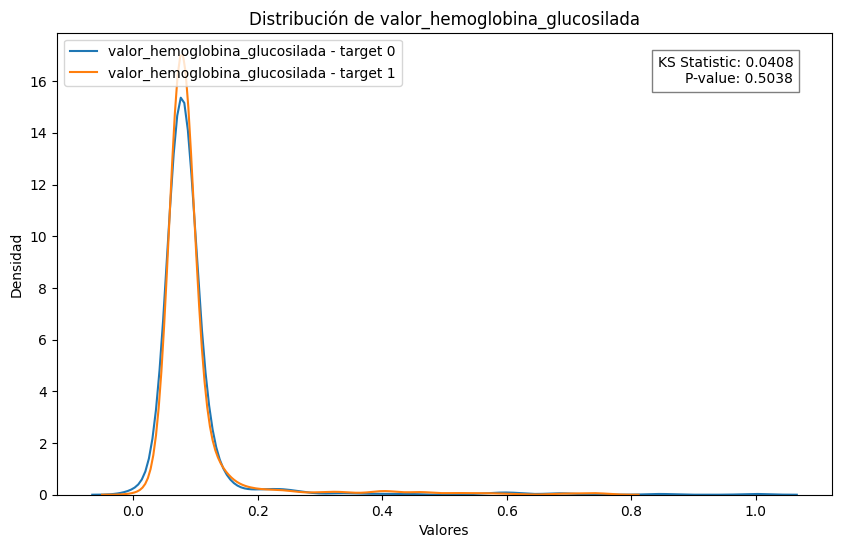

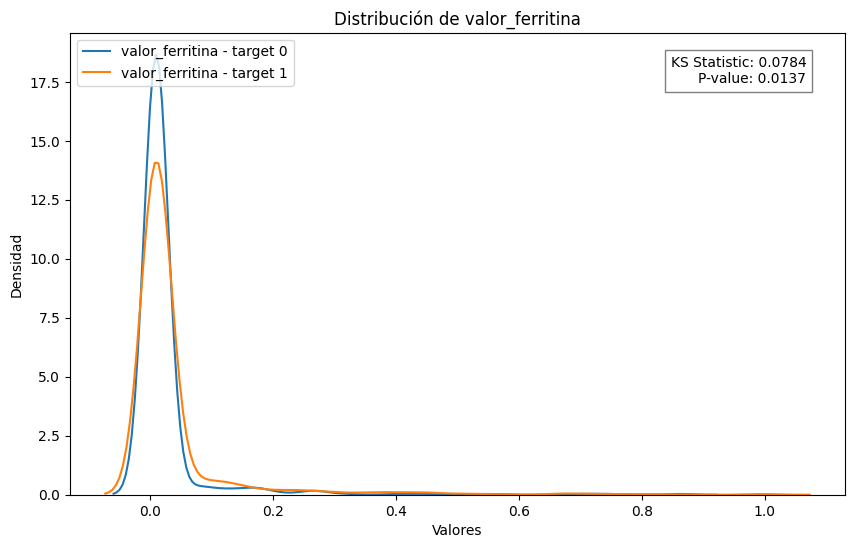

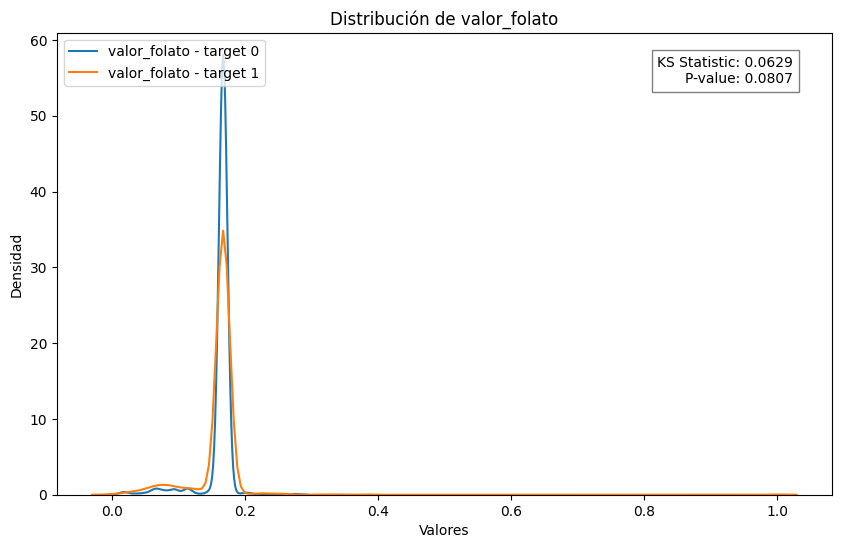

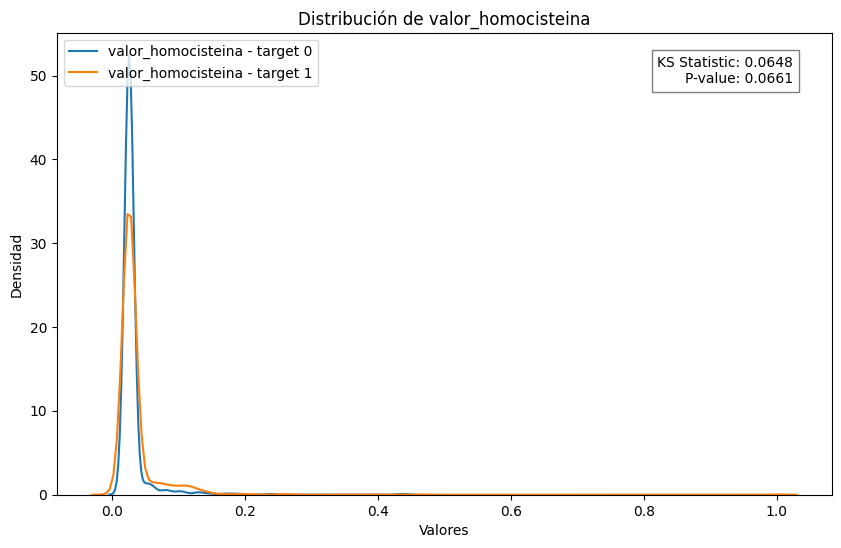

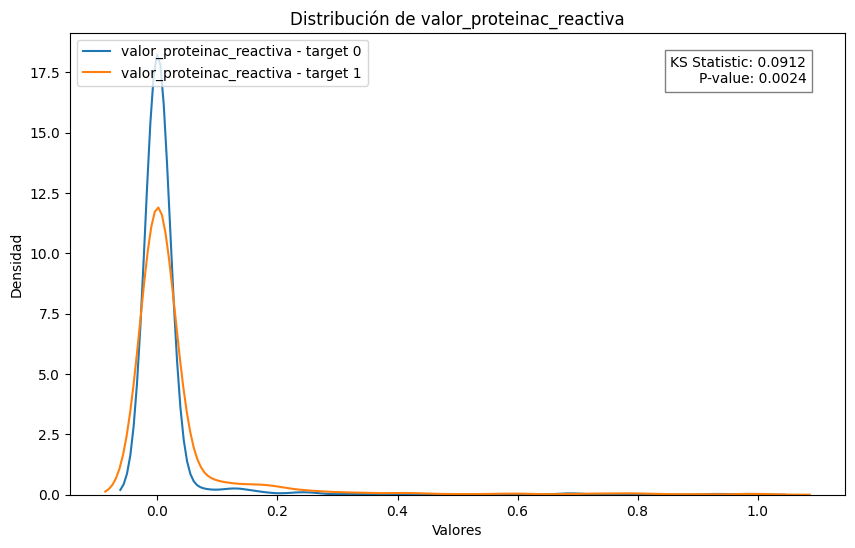

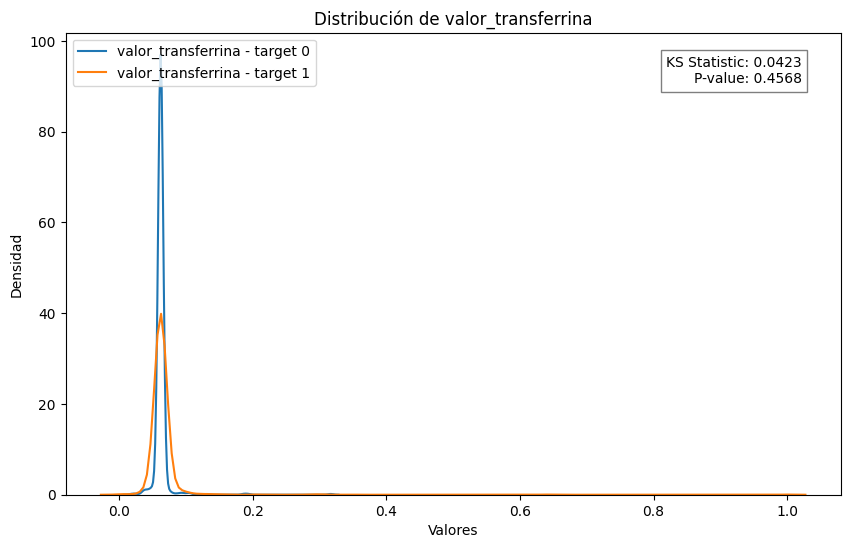

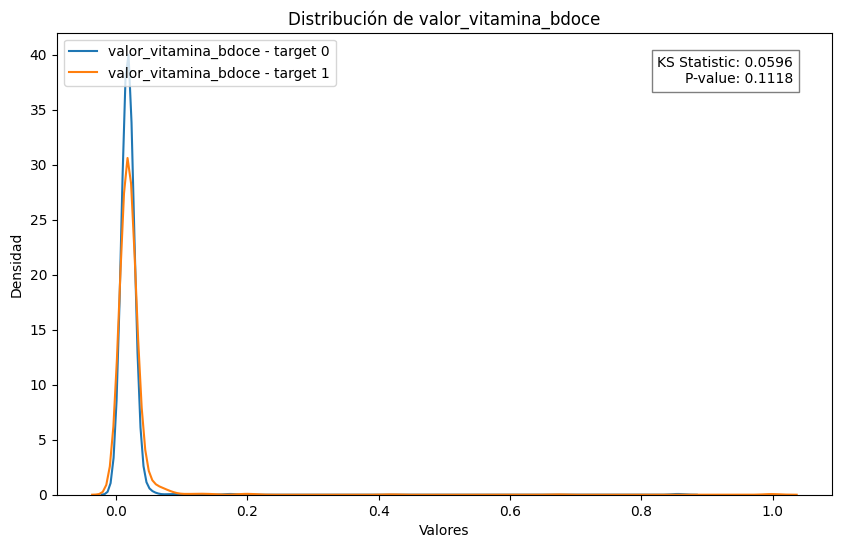

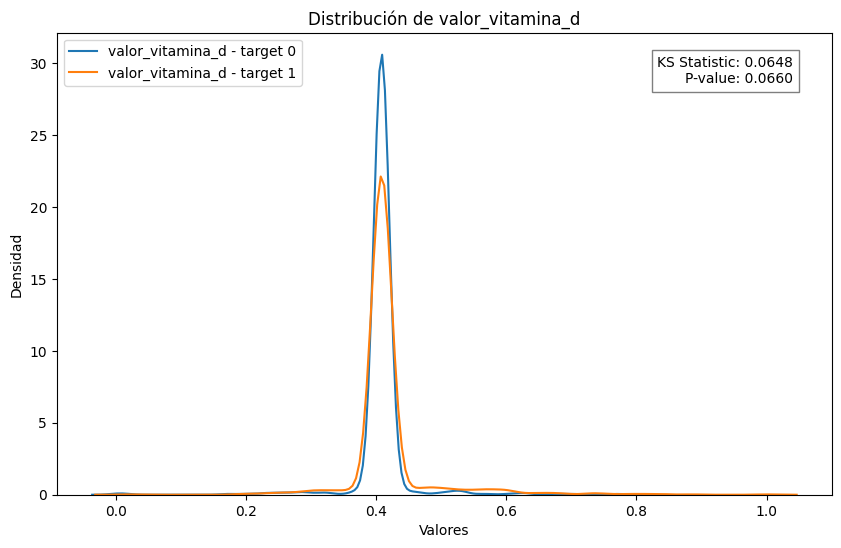

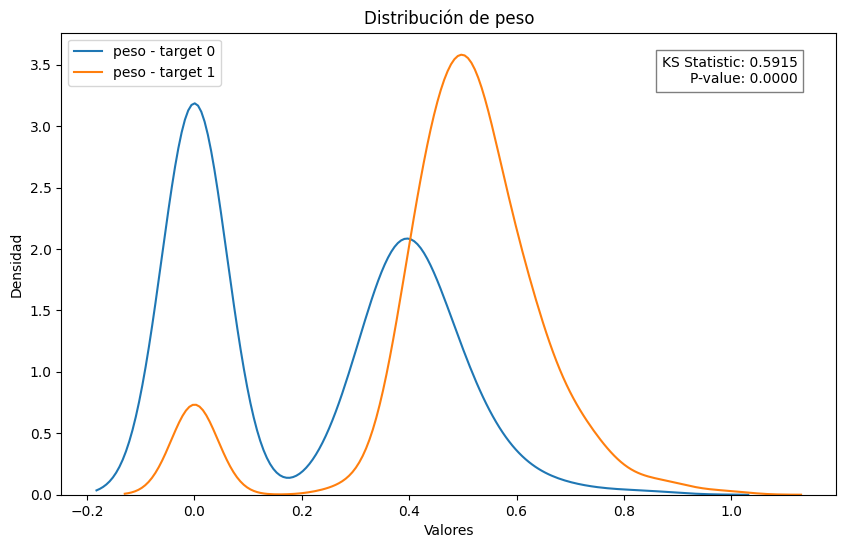

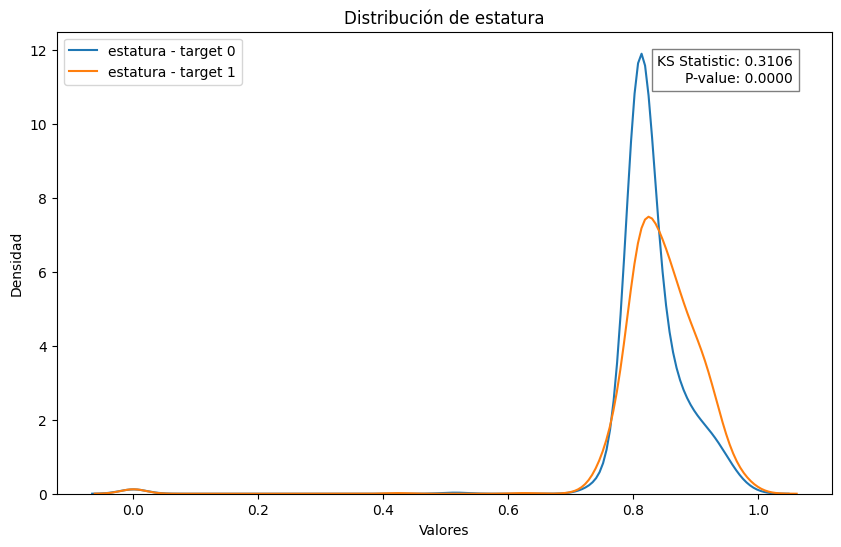

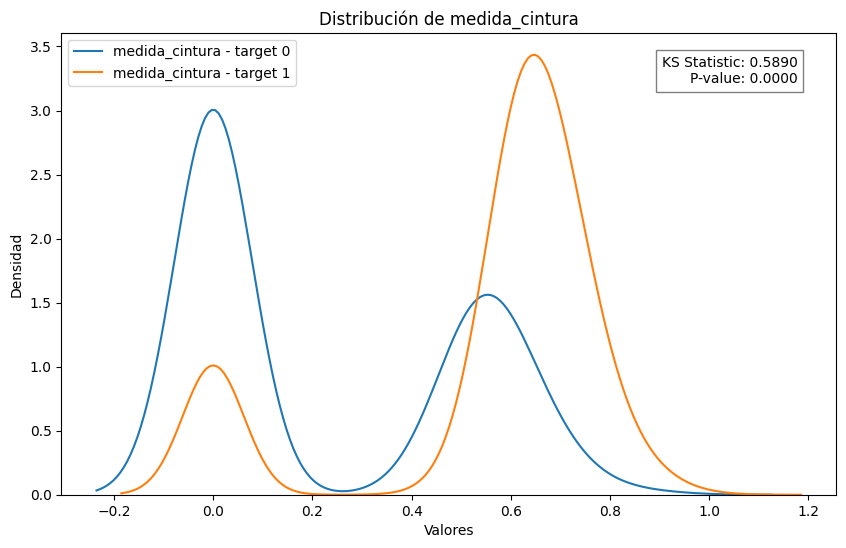

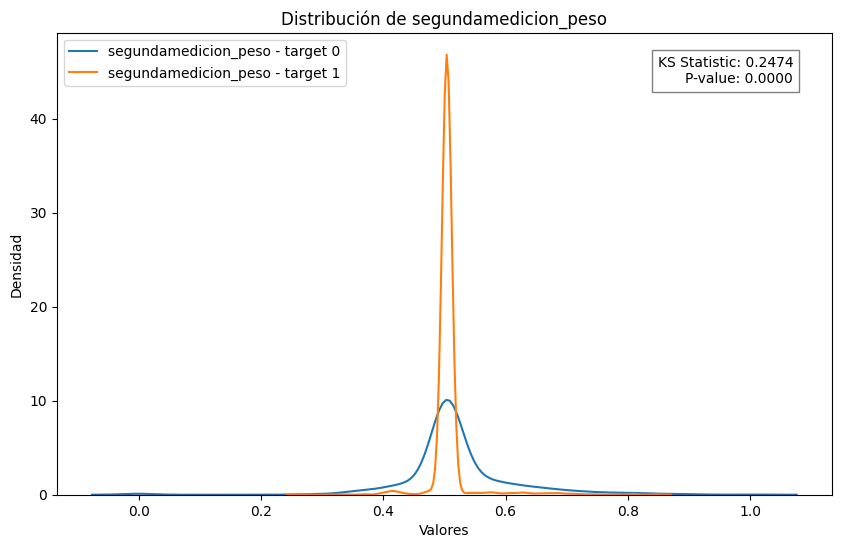

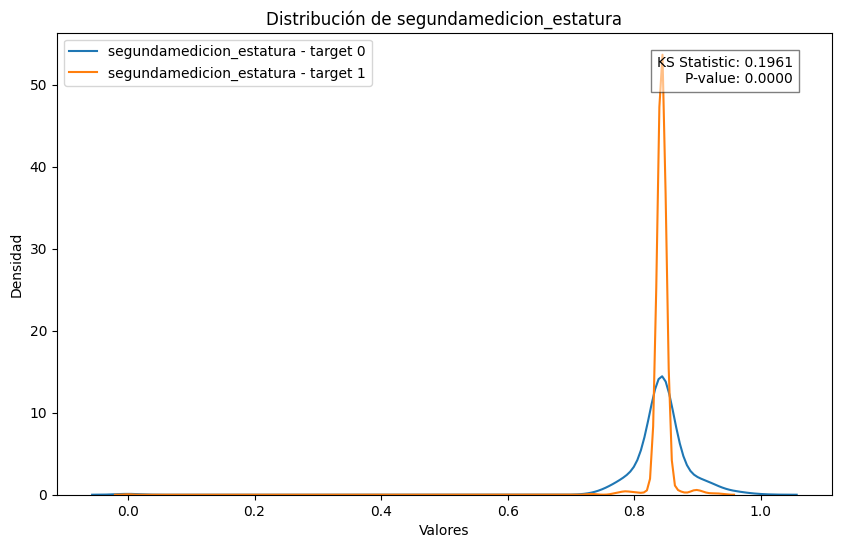

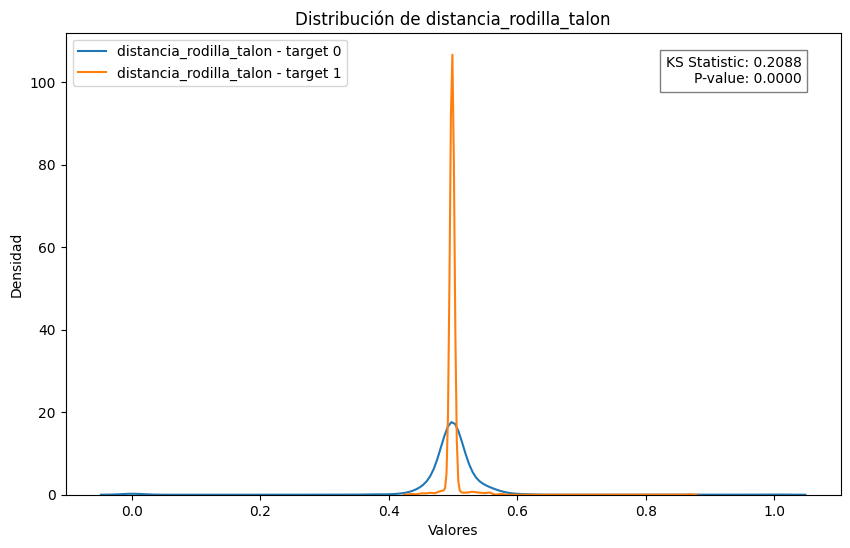

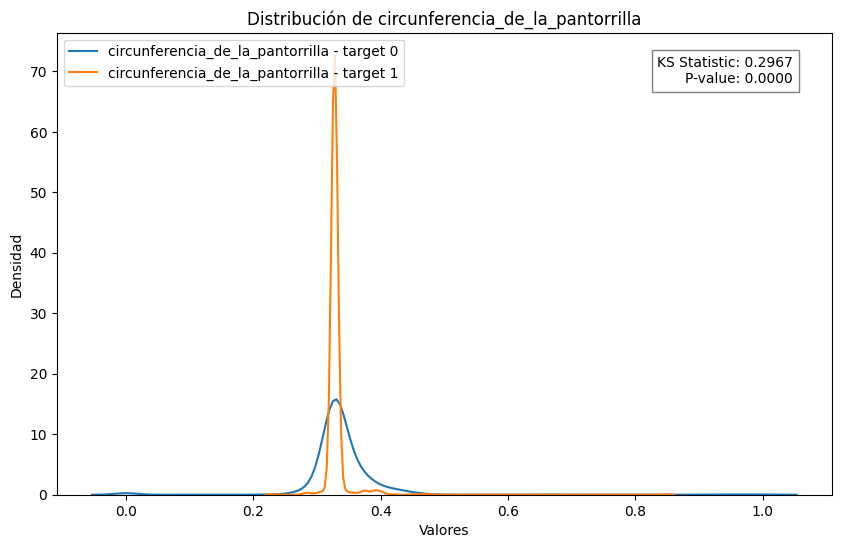

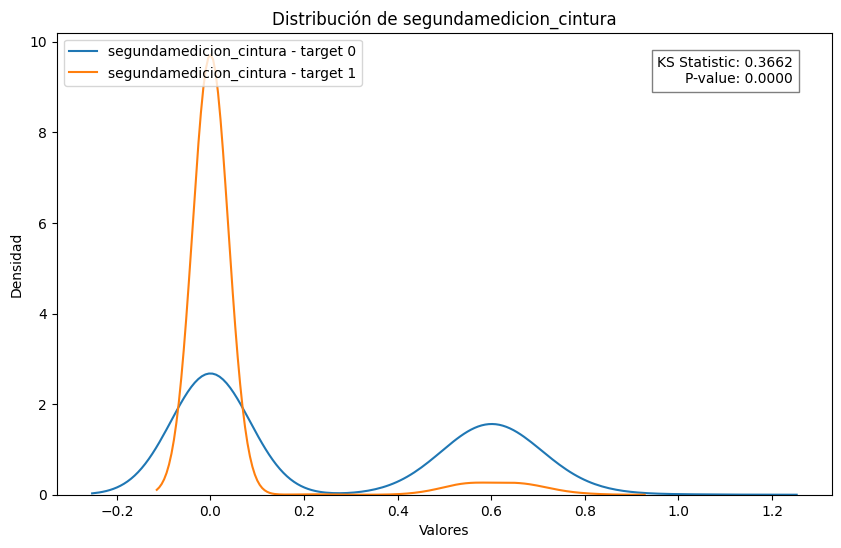

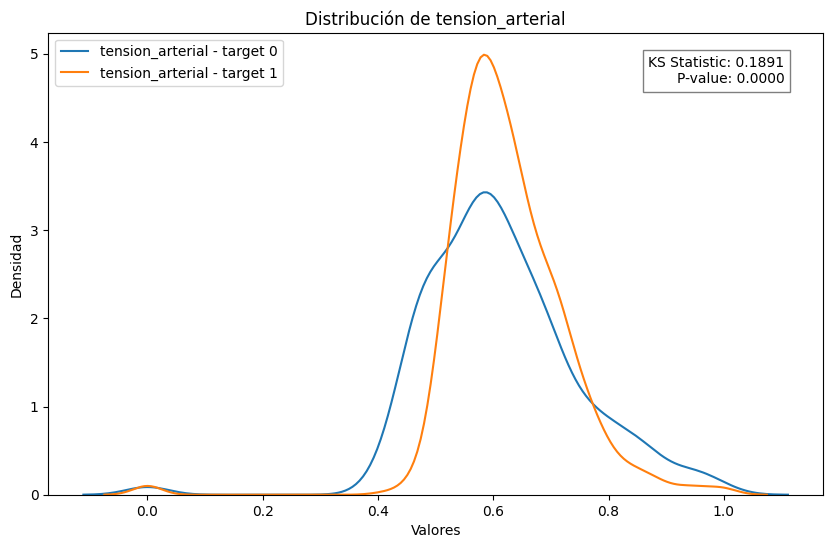

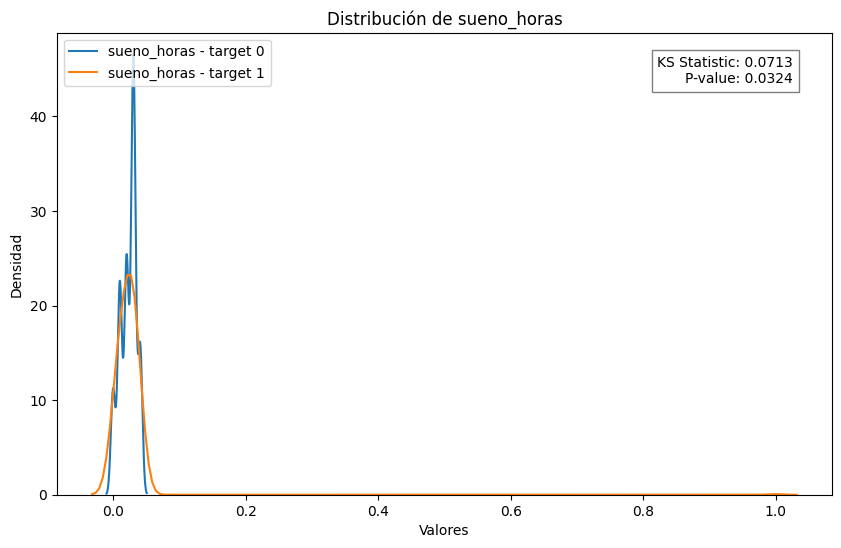

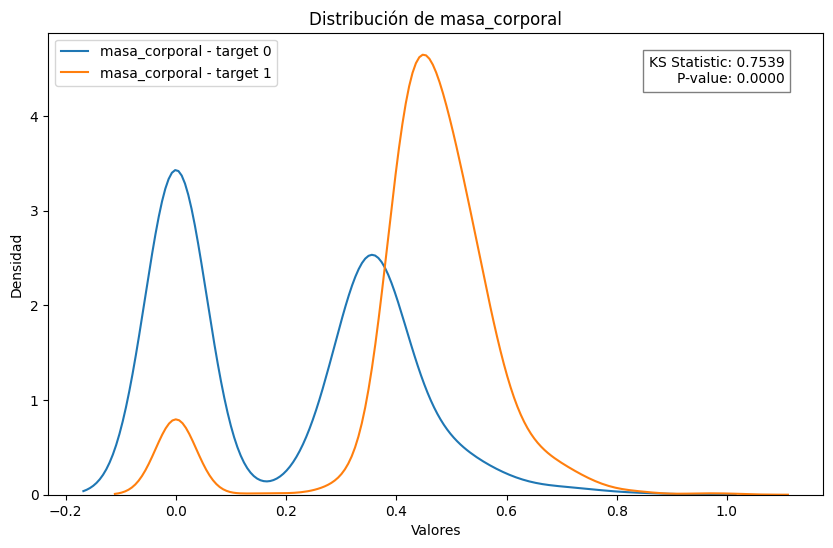

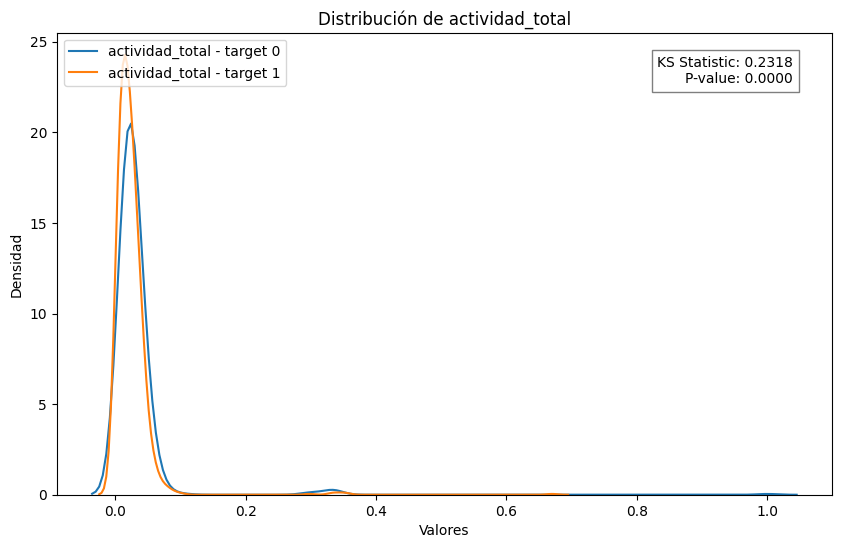

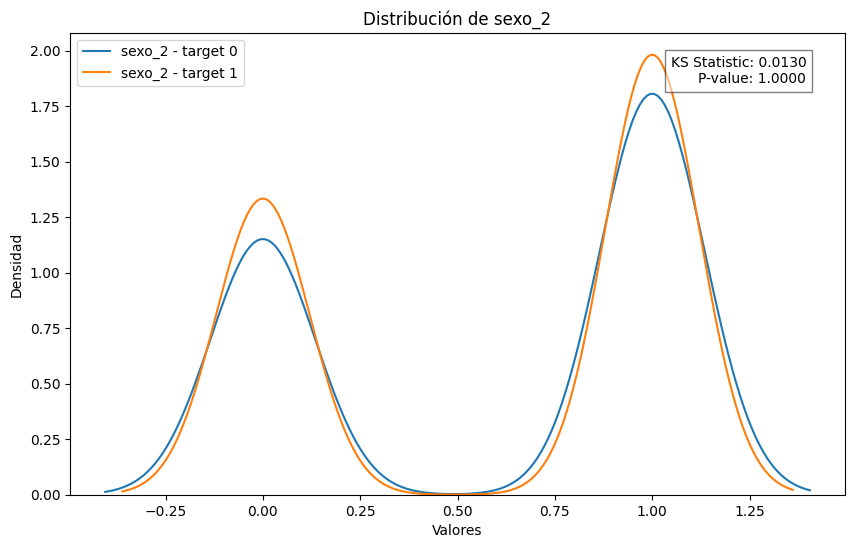

In [4]:
for column in X_train.columns:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(processed_df.loc[processed_df[target] == 0, column], label=f"{column} - target 0")
    sns.kdeplot(processed_df.loc[processed_df[target] == 1, column], label=f"{column} - target 1")
    
    # Calcular la prueba KS
    data_target0 = processed_df.loc[processed_df[target] == 0, column]
    data_target1 = processed_df.loc[processed_df[target] == 1, column]
    ks_statistic, p_value = stats.ks_2samp(data_target0, data_target1)
    
    plt.xlabel("Valores")
    plt.ylabel("Densidad")
    plt.title(f"Distribución de {column}")
    
    plt.text(0.95, 0.95, f"KS Statistic: {ks_statistic:.4f}\nP-value: {p_value:.4f}", 
             ha="right", va="top", transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))
    
    plt.legend(loc="upper left")  
    
    plt.show()

### Correlación de las características

In [12]:
corr_df = processed_df.corr().round(2) * 100
corr_df = corr_df.astype(int)

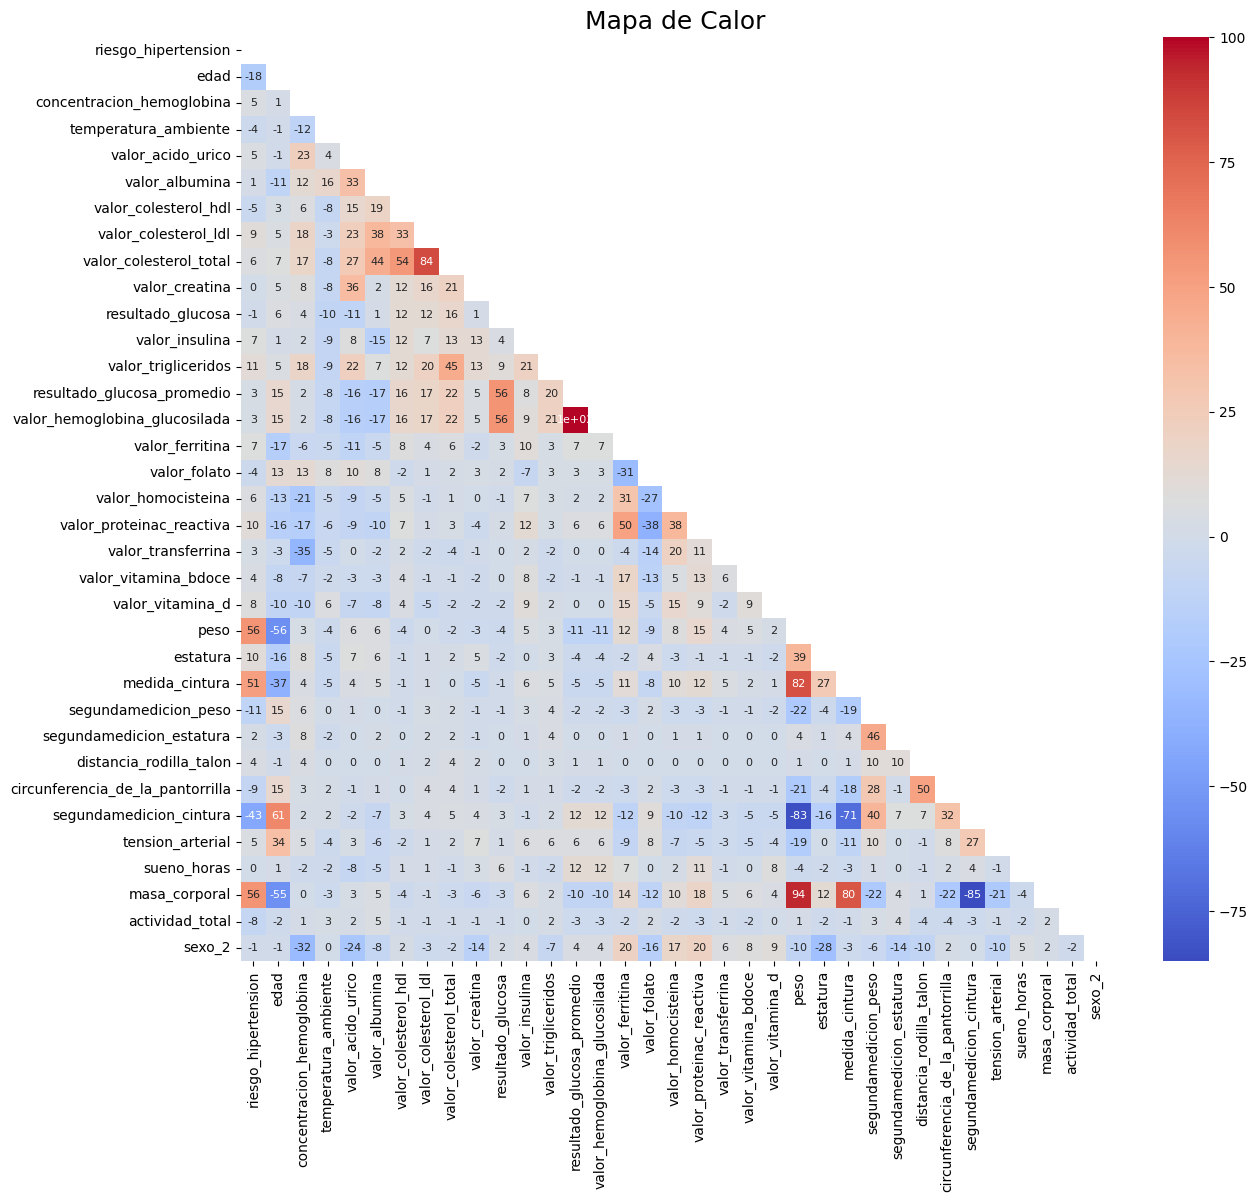

In [14]:
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(14, 12))
ax = sns.heatmap(corr_df, mask=mask, annot=True, cmap="coolwarm", annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title("Mapa de Calor", fontsize=18)
plt.show()

## Modelo base

In [45]:
models_dict = {
    "knn": KNeighborsClassifier(),
    "svc": SVC(probability=True, random_state=0),
    "logistic_regression": LogisticRegression(n_jobs=-1, random_state=0),
    "xgb": XGBClassifier(n_jobs=-1, random_state=0),
}

results_df = evaluate_models(models_dict, X_train, X_test, y_train, y_test)
results_df

/usr/local/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

,model,f1-score-train,std-dev,f1-score-test,roc-auc-test
0,knn,0.838397,0.0169,0.887227,0.91
1,svc,0.809724,0.0281,0.877858,0.92
2,logistic_regression,0.814890,0.0277,0.882751,0.91
3,xgb,0.989688,0.0088,0.992285,1.00


In [22]:
models_dict = {
    "knn": KNeighborsClassifier(),
    "svc": SVC(probability=True, random_state=0),
    "logistic_regression": LogisticRegression(n_jobs=-1, random_state=0),
    "xgb": XGBClassifier(n_jobs=-1, random_state=0),
}

results_df = evaluate_models(models_dict, X_train, X_test, y_train, y_test)
results_df

,model,f1-score-train,std-dev,f1-score-test,roc-auc-test
0,knn,0.856660,0.0197,0.887509,0.91
1,svc,0.834657,0.0251,0.883152,0.91
2,logistic_regression,0.832215,0.0253,0.879567,0.90
3,xgb,0.993279,0.0053,0.997865,1.00


## Selección de características

#### Selección por correlación

In [8]:
target_corr = corr_df[target].abs().sort_values(ascending=False)
target_corr.to_frame().describe()

,riesgo_hipertension
count,35.000000
mean,13.600000
std,21.469815
min,0.000000
25%,3.500000
50%,6.000000
75%,10.000000
max,100.000000


**Seleccionando las características más correlacionadas con la variable objetivo**

In [9]:
# Conservando el 75% de las features
threshold_target_corr = target_corr.quantile(0.25)

selected_features = target_corr[target_corr >= threshold_target_corr].index.tolist()
selected_features.remove(target)

len(selected_features)

25

**Eliminando características altamente correlacionadas entre sí**

In [10]:
selected_features_df = processed_df[selected_features]
selected_features_corr = selected_features_df.corr().abs()
threshold_feature_corr = 0.8
uncorrelated_features = set(selected_features)

for feature in selected_features:
    if feature in uncorrelated_features:
        highly_corr_features = selected_features_corr[feature][selected_features_corr[feature] > threshold_feature_corr].index.tolist()
        for corr_feature in highly_corr_features:
            if corr_feature != feature:
                uncorrelated_features.discard(corr_feature)

best_features_by_corr = list(uncorrelated_features)
print(len(best_features_by_corr))

for indice, feat in enumerate(best_features_by_corr, start=1):
    print(f"{indice}. {feat}", sep="\n")

21
1. tension_arterial
2. valor_acido_urico
3. valor_vitamina_d
4. valor_insulina
5. estatura
6. distancia_rodilla_talon
7. edad
8. circunferencia_de_la_pantorrilla
9. actividad_total
10. valor_colesterol_hdl
11. valor_trigliceridos
12. valor_colesterol_ldl
13. valor_vitamina_bdoce
14. segundamedicion_peso
15. temperatura_ambiente
16. valor_ferritina
17. valor_folato
18. valor_homocisteina
19. concentracion_hemoglobina
20. valor_proteinac_reactiva
21. masa_corporal


### Selección por RFE

In [11]:
model = LogisticRegression(n_jobs=-1)
best_features_by_rfe = get_best_features_rfecv(X_train, y_train, model, scoring="roc_auc")
print("Total de features", len(best_features_by_rfe))

for indice, feat in enumerate(best_features_by_rfe, start=1):
    print(f"{indice}. {feat}", sep="\n")

/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Total de features 15
1. edad
2. concentracion_hemoglobina
3. valor_colesterol_hdl
4. valor_colesterol_ldl
5. valor_trigliceridos
6. resultado_glucosa_promedio
7. valor_hemoglobina_glucosilada
8. valor_vitamina_d
9. peso
10. estatura
11. medida_cintura
12. segundamedicion_cintura
13. tension_arterial
14. masa_corporal
15. actividad_total


### Selección por XGBoost

In [13]:
model = LogisticRegression(n_jobs=-1)
results_xgb = dao.modeling_by_xgb_importance(
    model_name="logistic regression", model=model, x_train=X_train,
    y_train=y_train, x_test=X_test, y_test=y_test
)

results_xgb.head()

,Models,Id,No_features,ROC,ROC_AUC,F1,Recall,Accuracy,Brier,Importance_type,Best_features
0,logistic regression,model_1,28,0.8,0.91,88.0,92.0,83.0,17.0,total_gain,"temperatura_ambiente,sexo_2,valor_folato,valor..."
1,logistic regression,model_29,28,0.8,0.91,88.0,92.0,83.0,17.0,total_cover,"segundamedicion_estatura,sexo_2,valor_vitamina..."
2,logistic regression,model_57,28,0.8,0.91,88.0,92.0,83.0,17.0,weight,"temperatura_ambiente,valor_folato,valor_transf..."
3,logistic regression,model_85,28,0.8,0.91,88.0,92.0,83.0,17.0,gain,"temperatura_ambiente,sexo_2,edad,valor_creatin..."
4,logistic regression,model_113,28,0.8,0.91,88.0,92.0,83.0,17.0,cover,"sexo_2,segundamedicion_estatura,estatura,circu..."


In [14]:
best_feats_str = results_xgb.loc[0, "Best_features"]
best_features_by_xgb = best_feats_str.split(",")
print(len(best_features_by_xgb))

for indice, feat in enumerate(best_features_by_xgb, start=1):
    print(f"{indice}. {feat}", sep="\n")

28
1. temperatura_ambiente
2. sexo_2
3. valor_folato
4. valor_transferrina
5. valor_vitamina_bdoce
6. valor_vitamina_d
7. segundamedicion_estatura
8. valor_homocisteina
9. circunferencia_de_la_pantorrilla
10. valor_creatina
11. sueno_horas
12. valor_acido_urico
13. edad
14. valor_albumina
15. valor_insulina
16. estatura
17. resultado_glucosa_promedio
18. medida_cintura
19. peso
20. valor_trigliceridos
21. valor_colesterol_ldl
22. resultado_glucosa
23. concentracion_hemoglobina
24. valor_colesterol_hdl
25. valor_colesterol_total
26. tension_arterial
27. actividad_total
28. masa_corporal


## Modelado con las mejores características

### Logistic Regression

**GridSearch**

In [54]:
param_grid = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["newton-cg", "newton-cholesky", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 200, 300, 400, 500]
}

features_dict = {
    "corr": best_features_by_corr,
    "rfe": best_features_by_rfe,
    "xgb": best_features_by_xgb,
}

model = LogisticRegression(n_jobs=-1)

results_list = []
for score_type, top_features in features_dict.items():
    results =  train_classifier_model(
        X_train[top_features], X_test[top_features], y_train, y_test,
        model=model, param_grid=param_grid, verbose=False
    )
    model, best_params, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc  = results

    results_list.append([score_type, model, best_params, f1_mean_score_train,
                         std_dev_train, f1_score_test, roc_auc])
    
lr_metrics_df = pd.DataFrame(results_list, columns=["score_type", "model", "best_params", "f1-score-train", "std-dev", "f1-score-test", "roc-auc"])
lr_metrics_df

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:

Mejores hiperparámetros encontrados GridSearchCV:
{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cholesky'}


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:

Mejores hiperparámetros encontrados GridSearchCV:
{'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:

Mejores hiperparámetros encontrados GridSearchCV:
{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

,score_type,model,best_params,f1-score-train,std-dev,f1-score-test,roc-auc
0,corr,"LogisticRegression(C=10, n_jobs=-1, solver='ne...","{'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...",0.824621,0.0246,0.879320,0.91
1,rfc,"LogisticRegression(C=100, n_jobs=-1, penalty='...","{'C': 100, 'max_iter': 100, 'penalty': 'l1', '...",0.830923,0.0191,0.886207,0.91
2,xgb,"LogisticRegression(C=100, n_jobs=-1)","{'C': 100, 'max_iter': 100, 'penalty': 'l2', '...",0.824062,0.0209,0.881952,0.91


### XGB

**GridSearch**

In [15]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.2, 0.4],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}


features_dict = {
    "corr": best_features_by_corr,
    "rfe": best_features_by_rfe,
    "xgb": best_features_by_xgb
}

model = XGBClassifier(n_jobs=-1)

results_list = []
for score_type, top_features in features_dict.items():
    results =  train_classifier_model(
        X_train[top_features], X_test[top_features], y_train, y_test,
        model=model, param_grid=param_grid, verbose=False
    )
    model, best_params, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc  = results

    results_list.append([score_type, model, best_params, f1_mean_score_train,
                         std_dev_train, f1_score_test, roc_auc])
    
xgb_metrics_df = pd.DataFrame(results_list, columns=["score_type", "model", "best_params", "f1-score-train", "std-dev", "f1-score-test", "roc-auc"])
xgb_metrics_df

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


,score_type,model,best_params,f1-score-train,std-dev,f1-score-test,roc-auc
0,corr,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 0.8, 'gamma': 0.4, 'learn...",0.987392,0.0067,0.987493,1.0
1,rfe,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 0.8, 'gamma': 0.4, 'learn...",0.989698,0.0088,0.992276,1.0
2,xgb,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 1.0, 'gamma': 0, 'learnin...",0.991977,0.0082,0.994083,1.0


In [16]:
best_df = xgb_metrics_df[xgb_metrics_df["score_type"] == "rfe"]
best_model = best_df["model"].values[0]
best_features = best_features_by_rfe

# Guardando el mejor modelo
with open("../results/10-Hipertension-Mexico/best_model.pickle", "wb") as f:
    pickle.dump(best_model, f)
# Guardando las mejores características
with open("../results/10-Hipertension-Mexico/best_features.pickle", "wb") as f:
    pickle.dump(best_features, f)

In [15]:
# Guardando el mejor modelo
with open("../results/10-Hipertension-Mexico/best_model.pickle", "rb") as f:
    best_model = pickle.load(f)

s = ["learning_rate", "n_estimators", "max_depth",
     "min_child_weight", "gamma", "subsample", "colsample_bytree"]

for i in s:
    print(i, ": ", best_model.get_params()[i])

learning_rate :  0.1
n_estimators :  100
max_depth :  4
min_child_weight :  1
gamma :  0.4
subsample :  1.0
colsample_bytree :  0.8


In [18]:
print(best_model.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.4, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


## Evaluación del modelo

### Predicción sobre datos de validación

In [5]:
with open("../results/10-Hipertension-Mexico/numerical_features.pickle", "rb") as f:
    numerical_features = pickle.load(f)

with open("../results/10-Hipertension-Mexico/categorical_features.pickle", "rb") as f:
    categorical_features = pickle.load(f)

with open("../results/10-Hipertension-Mexico/preprocessor.pickle", "rb") as f:
    preprocessor = pickle.load(f)

with open("../results/10-Hipertension-Mexico/best_model.pickle", "rb") as f:
    best_model = pickle.load(f)

with open("../results/10-Hipertension-Mexico/best_features.pickle", "rb") as f:
    best_features = pickle.load(f)

target = "riesgo_hipertension"
X_val_raw = pd.read_pickle("../results/10-Hipertension-Mexico/X_val_raw.pickle")
y_val_raw = pd.read_pickle("../results/10-Hipertension-Mexico/y_val.pickle")
y_val = pd.DataFrame(y_val_raw)

predictions_df = y_val[[target]].copy()

transformed_X = preprocessor.transform(X_val_raw)
onehot_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
categorical_features_encoded = onehot_encoder.get_feature_names_out(
        input_features=categorical_features)

feature_names =  numerical_features + list(categorical_features_encoded)

X_val = pd.DataFrame(transformed_X, columns=feature_names)
X_val.to_pickle("../results/10-Hipertension-Mexico/X_val.pickle")

X_val.head()

,edad,concentracion_hemoglobina,temperatura_ambiente,valor_acido_urico,valor_albumina,valor_colesterol_hdl,valor_colesterol_ldl,valor_colesterol_total,valor_creatina,resultado_glucosa,valor_insulina,valor_trigliceridos,resultado_glucosa_promedio,valor_hemoglobina_glucosilada,valor_ferritina,valor_folato,valor_homocisteina,valor_proteinac_reactiva,valor_transferrina,valor_vitamina_bdoce,valor_vitamina_d,peso,estatura,medida_cintura,segundamedicion_peso,segundamedicion_estatura,distancia_rodilla_talon,circunferencia_de_la_pantorrilla,segundamedicion_cintura,tension_arterial,sueno_horas,masa_corporal,actividad_total,sexo_2
0,0.674157,0.604167,0.606061,0.425926,0.697674,0.078947,0.396506,0.390438,0.037547,0.021879,0.012903,0.100114,0.077748,0.076923,0.009677,0.167429,0.025707,0.0,0.062112,0.017832,0.408528,0.000000,0.810956,0.000000,0.451768,0.803395,0.461459,0.404692,0.509091,0.715,0.020408,0.000000,0.028636,1.0
1,0.134831,0.604167,0.606061,0.425926,0.697674,0.078947,0.396506,0.390438,0.037547,0.021879,0.012903,0.100114,0.077748,0.076923,0.009677,0.167429,0.025707,0.0,0.062112,0.017832,0.408528,0.276426,0.823308,0.000000,0.504019,0.843373,0.498458,0.327468,0.000000,0.575,0.000000,0.270208,0.031443,1.0
2,0.651685,0.604167,0.606061,0.425926,0.697674,0.078947,0.396506,0.390438,0.037547,0.021879,0.012903,0.100114,0.077748,0.076923,0.009677,0.167429,0.025707,0.0,0.062112,0.017832,0.408528,0.000000,0.810956,0.000000,0.500804,0.789157,0.479959,0.315738,0.598788,0.780,0.010204,0.000000,0.023021,1.0
3,0.752809,0.402778,0.636364,0.351852,0.744186,0.116541,0.576496,0.581673,0.040050,0.059631,0.028083,0.175199,0.284182,0.284615,0.009677,0.167429,0.025707,0.0,0.062112,0.017832,0.408528,0.000000,0.810956,0.000000,0.497588,0.857612,0.503597,0.365591,0.572121,0.600,0.030612,0.000000,0.003650,1.0
4,0.550562,0.604167,0.606061,0.425926,0.697674,0.078947,0.396506,0.390438,0.037547,0.021879,0.012903,0.100114,0.077748,0.076923,0.009677,0.167429,0.025707,0.0,0.062112,0.017832,0.408528,0.402643,0.838883,0.521368,0.504019,0.843373,0.498458,0.327468,0.000000,0.625,0.000000,0.380141,0.024705,1.0


In [24]:
y_prob = best_model.predict_proba(X_val[best_features])[:, 1]
y_pred = best_model.predict(X_val[best_features])

predictions_df["y_prob"] = y_prob
predictions_df["y_pred"] = y_pred
predictions_df.shape

(1309, 3)

### Métricas de evaluación

In [25]:
f1 = round(f1_score(y_val, y_pred), 4)
roc_auc = round(roc_auc_score(y_val, y_prob), 4)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)

F1 Score: 0.9952
ROC AUC: 0.9987
Confusion Matrix:
[[463   1]
 [  7 838]]


In [21]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       464
           1       1.00      0.99      1.00       845

    accuracy                           0.99      1309
   macro avg       0.99      0.99      0.99      1309
weighted avg       0.99      0.99      0.99      1309



## Estabilidad del modelo

In [3]:
# Leyendo características ya transformadas
X_train_transformed = pd.read_pickle("../results/10-Hipertension-Mexico/X_train.pickle")
X_val_transformed = pd.read_pickle("../results/10-Hipertension-Mexico/X_val.pickle")
# Leyendo target
y_train = pd.read_pickle("../results/10-Hipertension-Mexico/y_train.pickle")
y_val = pd.read_pickle("../results/10-Hipertension-Mexico/y_val.pickle")

#### Population Stability Index (PSI)

In [30]:
psi_results = []
for feat in best_features:
    psi_value = calculate_psi(X_train_transformed[feat], X_val_transformed[feat], buckets=3)
    psi_interpretation = interpret_psi(psi_value)
    psi_results.append({"Característica": feat, "Valor PSI": psi_value, "Interpretación": psi_interpretation})

psi_results_df = pd.DataFrame(psi_results)
psi_results_df

/tmp/ipykernel_785/2007159006.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents)))


,Característica,Valor PSI,Interpretación
0,edad,0.0033,No hay cambios significativos
1,concentracion_hemoglobina,0.0074,No hay cambios significativos
2,valor_colesterol_hdl,0.3399,Grandes cambios
3,valor_colesterol_ldl,3.9001,Grandes cambios
4,valor_trigliceridos,0.0010,No hay cambios significativos
5,resultado_glucosa_promedio,0.1191,Pequeños cambios
6,valor_hemoglobina_glucosilada,0.0083,No hay cambios significativos
7,valor_vitamina_d,0.0053,No hay cambios significativos
8,peso,0.1023,Pequeños cambios
9,estatura,0.0024,No hay cambios significativos


In [31]:
psi_results_df["Interpretación"].value_counts(normalize=False).to_frame()

,count
Interpretación,
No hay cambios significativos,9
Pequeños cambios,4
Grandes cambios,2


**PSI sobre las probabilidades**
Cálculadas con el modelo entrenado para los datos de train y test

In [23]:
y_train_prob = best_model.predict_proba(X_train[best_features])[:, 1]
y_val_prob = best_model.predict_proba(X_val[best_features])[:, 1]

In [24]:
psi_value = calculate_psi(X_train_transformed[feat], X_val_transformed[feat], buckets=3)
psi_interpretation = interpret_psi(psi_value)
print(psi_value, psi_interpretation)

0.036 No hay cambios significativos


/tmp/ipykernel_785/2007159006.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents)))


### Desempeño del poder predictivo

In [70]:
from sklearn.feature_selection import SelectKBest, f_classif

target = "riesgo_hipertension"
data_train = pd.concat([y_train, X_train], axis=1)
data_val = pd.concat([y_val.reset_index(drop=True), X_val], axis=1)


restuls_kb = []
for feat in best_features:
    kb = SelectKBest(k=1, score_func=f_classif) # Medición de poder predictivo
    kb.fit(data_train[[feat]], data_train[target])
    score_train = kb.scores_[0]
    kb = SelectKBest(k=1, score_func=f_classif)
    kb.fit(data_val[[feat]], data_val[target])
    score_val = kb.scores_[0]

    restuls_kb.append({
        "Característica": feat,
        "Poder predictivo train": round(score_train, 2),
        "Poder predictivo val": round(score_val, 2),
        }
    )

kb_results_df = pd.DataFrame(restuls_kb)
kb_results_df["Tasa_Crecimiento"] = round(((kb_results_df["Poder predictivo val"] - kb_results_df["Poder predictivo train"]) / kb_results_df["Poder predictivo train"]) * 100, 2)
kb_results_df

,Característica,Poder predictivo train,Poder predictivo val,Tasa_Crecimiento
0,edad,60.28,87.89,45.80
1,concentracion_hemoglobina,3.64,4.66,28.02
2,valor_colesterol_hdl,3.93,0.52,-86.77
3,valor_colesterol_ldl,12.82,9.03,-29.56
4,valor_trigliceridos,20.74,17.92,-13.60
5,resultado_glucosa_promedio,1.20,1.33,10.83
6,valor_hemoglobina_glucosilada,1.23,0.83,-32.52
7,valor_vitamina_d,12.68,5.10,-59.78
8,peso,789.55,750.39,-4.96
9,estatura,16.84,43.24,156.77


## Estabilidad Kolmogorov-Smirnov (KS)

In [51]:
from scipy.stats import ks_2samp

target = "riesgo_hipertension"
data_train = pd.concat([y_train, X_train], axis=1)

ks_results = {}
for column in best_features:
    # Obtener las series de la característica en ambos conjuntos de datos
    target_0_data = data_train.loc[data_train[target] == 0, column]
    target_1_data = data_train.loc[data_train[target] == 1, column]
    
    # Realizar la prueba KS
    ks_stat, p_value = ks_2samp(target_0_data, target_1_data)
    
    # Guardar los resultados en el diccionario
    ks_results[column] = {"ks_stat": ks_stat, "p_value": round(p_value, 4)}

# Convertir los resultados en un DataFrame para una visualización más fácil
ks_results_df = pd.DataFrame(ks_results).T
ks_results_df = ks_results_df.reset_index()

In [53]:
ks_results_df = ks_results_df.rename(columns={
    "index": "Característica"
})

In [54]:
ks_results_df

,Característica,ks_stat,p_value
0,edad,0.402220,0.0000
1,concentracion_hemoglobina,0.062513,0.0836
2,valor_colesterol_hdl,0.043078,0.4334
3,valor_colesterol_ldl,0.070201,0.0367
4,valor_trigliceridos,0.075995,0.0186
5,resultado_glucosa_promedio,0.040766,0.5038
6,valor_hemoglobina_glucosilada,0.040766,0.5038
7,valor_vitamina_d,0.064814,0.0660
8,peso,0.591456,0.0000
9,estatura,0.310637,0.0000


### Punto de corte óptimo

In [26]:
from sklearn.metrics import roc_curve, auc
import numpy as np

y_val = pd.read_pickle("../results/10-Hipertension-Mexico/y_val.pickle")
X_val_transformed = pd.read_pickle("../results/10-Hipertension-Mexico/X_val.pickle")


y_prob = best_model.predict_proba(X_val_transformed[best_features])[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)
# Calcular Índice de Youden
iv = tpr - fpr
# Encontrar el umbral óptimo según el Índice de Youden
optimal_threshold = thresholds[np.argmax(iv)]
print("Umbral óptimo según el Índice de Youden:", optimal_threshold)

Umbral óptimo según el Índice de Youden: 0.6178568


## TN y TNE

In [27]:
df = pd.concat([y_train, X_train_transformed[best_features]], axis=1)

df["prob"] = best_model.predict_proba(X_train_transformed[best_features])[:, 1]
df["decile"] = pd.cut(df["prob"], bins=[0, 0.6, 1], include_lowest=True)

In [28]:
aux = df.pivot_table(index="decile",
                     columns=target,
                    values=best_features[0],
                    fill_value=0,
                    aggfunc="count").reset_index()

/tmp/ipykernel_51964/520571066.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  aux = df.pivot_table(index="decile",


In [29]:
def get_use_model(aux_):
    aux_['Total']=aux_[0]+aux_[1]
    aux_['%Dist']=aux_['Total']/aux_['Total'].sum()
    aux_['TNE']=aux_[0]/aux_['Total']
    aux_['TE']=aux_[1]/aux_['Total']
    aux_['Acum NE']=aux_[0].cumsum()/aux_[0].sum()
    aux_['Acum E']=aux_[1].cumsum()/aux_[1].sum()
    aux_['Dif']=abs(aux_['Acum NE']-aux_['Acum E'])
    aux_['Lift']=aux_['TE']/aux_['TE'].sum()
    aux_['WoE']=np.log(aux_['TNE']/aux_['TE'])
    aux_['IV']=(aux_['TNE']-aux_['TE'])*aux_['WoE']
    print('IV: '+str(round(aux_['IV'].sum(),2)))
    return aux_

def get_graphs(aux_):
    x=[str(y) for y in aux_['decile']]
    data = [
        go.Pie(labels=x,
                   values=list(aux_['%Dist']),
                  name='%Dist'
                  ),
           ]
    layout = go.Layout( title = '%Dist')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    data = [
        go.Bar(x=x,
                   y=list(aux_['%Dist']),
                  name='%Dist'
                  ),
           ]
    layout = go.Layout(barmode='stack', title = '%Dist')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    data = [
        go.Bar(x=x,
                   y=list(aux_['TNE']),
                  name='TNE'
                  ),

           go.Bar(x=x,
                   y=list(aux_['TE']),
                 name='TE'
                 )
           ]
    layout = go.Layout(barmode='stack', title = 'TE/TNE')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    
    print('KS: '+str(max(aux_['Dif'])))
    data = [
        go.Scatter(x=['']+x,
                   y=[0]+list(aux_['Acum NE']),
                  name='Acum NE',line_shape='spline'
                  ),

           go.Scatter(x=['']+x,
                   y=[0]+list(aux_['Acum E']),
                 name='Acum E',line_shape='spline'
                 )
           ]
    layout = go.Layout( title = 'KS')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    
    data = [
        go.Scatter(x=['']+x,
                   y=[0]+list(aux_['Lift']),
                  name='Lift',
                   line_shape='spline'
                  ),

           ]
    layout = go.Layout( title = 'Lift',)
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))

In [30]:
aux_=get_use_model(aux)
aux_

IV: inf


/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


riesgo_hipertension,decile,0,1,Total,%Dist,TNE,TE,Acum NE,Acum E,Dif,Lift,WoE,IV
0,"(-0.001, 0.6]",619,3,622,0.356447,0.995177,0.004823,1.0,0.002664,0.997336,0.0048,5.329493,5.278083
1,"(0.6, 1.0]",0,1123,1123,0.643553,0.000000,1.000000,1.0,1.000000,0.000000,0.9952,-inf,inf


In [31]:
import cufflinks as cf
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

cf.set_config_file(theme='solar', offline=True)

get_graphs(aux_)

None

None

None

KS: 0.9973357015985791


None

None

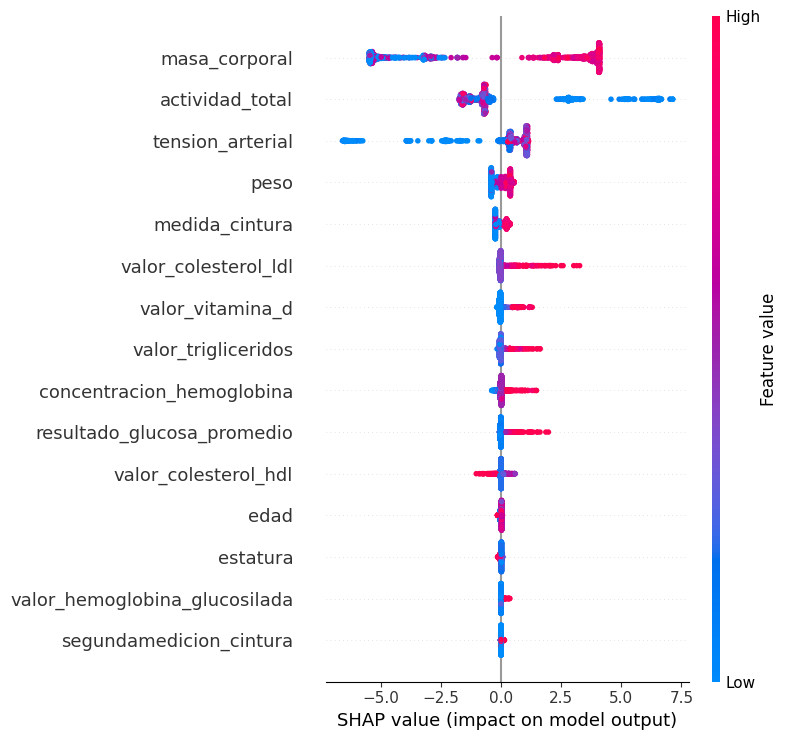

In [11]:
import shap
shap.initjs()

X_train = X_train_transformed[best_features]
X_val = X_val_transformed[best_features]

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

In [159]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

print_feature_importances_shap_values(shap_values, best_features)

masa_corporal -> 3.8230 (softmax = 0.7009)
actividad_total -> 1.2433 (softmax = 0.0531)
tension_arterial -> 1.0340 (softmax = 0.0431)
peso -> 0.2806 (softmax = 0.0203)
medida_cintura -> 0.1773 (softmax = 0.0183)
valor_colesterol_ldl -> 0.1666 (softmax = 0.0181)
valor_vitamina_d -> 0.1220 (softmax = 0.0173)
valor_trigliceridos -> 0.1082 (softmax = 0.0171)
concentracion_hemoglobina -> 0.0852 (softmax = 0.0167)
valor_colesterol_hdl -> 0.0693 (softmax = 0.0164)
resultado_glucosa_promedio -> 0.0686 (softmax = 0.0164)
estatura -> 0.0237 (softmax = 0.0157)
edad -> 0.0210 (softmax = 0.0156)
valor_hemoglobina_glucosilada -> 0.0136 (softmax = 0.0155)
segundamedicion_cintura -> 0.0082 (softmax = 0.0154)


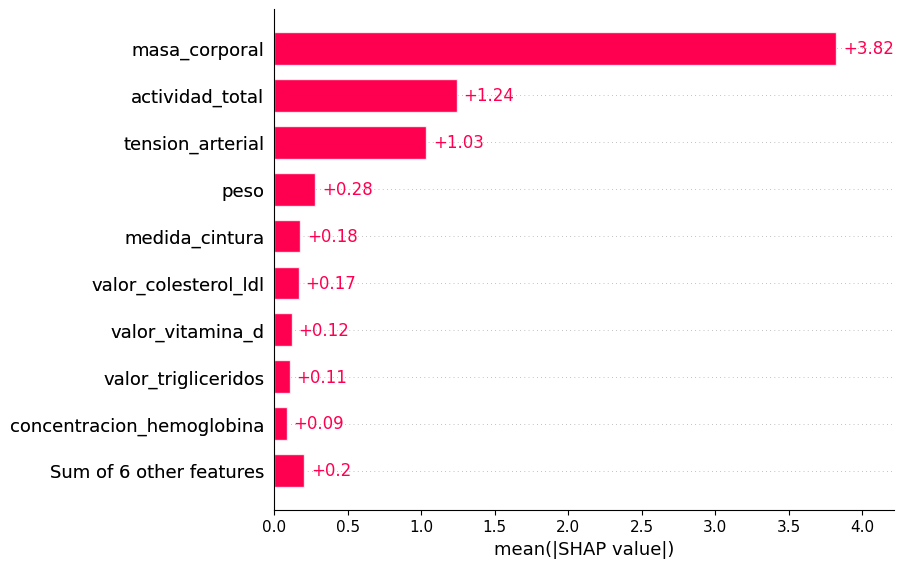

In [162]:
shap.plots.bar(shap_values)